In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


In [33]:
list_files('../Data/cohn-kanade-images/')

/
S111/
    007/
../Data/cohn-kanade-images/S111/007
../Data/cohn-kanade-images/S111/007S111_007_00000008.png


array([[  0,  35,  99, ...,   0,   0,   0],
       [  7,  61, 122, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [221, 226, 227, ..., 217, 214, 217],
       [222, 224, 230, ..., 214, 218, 216],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

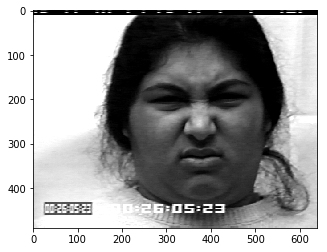

In [140]:
img = cv2.imread(list_files('../Data/cohn-kanade-images/')[0],0) # reads image as grayscale
img.
plt.imshow(img, cmap='gray')

In [82]:
def list_files(startpath):

    all_files = []
    for root, dirs, files in os.walk(startpath):
        if files and files[-1][-4] == '.':
            all_files.append(root + '/' + sorted(files)[-1])
    return sorted(all_files)

In [91]:
def find_matching(X, y):
    final_X = []
    final_y = []
    i, j = 0, 0
    while i < len(X):
        X_split = X[i].split('/')
        y_split = y[j].split('/')
        if X_split[3] == y_split[3] and X_split[4] == y_split[4]:
            final_X.append(X[i])
            final_y.append(y[j])
            j+=1
        i+=1
    return final_X, final_y

In [129]:
def read_Y(y):
    res_y = []
    for file in y:
        with open(file) as f:
            for line in f.readlines():
                res_y.append(float(line))
    return np.array(res_y)
    

In [199]:
def read_X(X):
    res_X = []
    for file in X:
        img = cv2.imread(file,0) # reads image as grayscale
        res_X.append(img)
    return np.array(res_X)

In [212]:
y_translation = {0:"neutral", 1:"anger", 2:"contempt", 3:"disgust", 4:"fear", 5:"happy", 6:"sadness", 7:"surprise"}
X, y = find_matching(list_files('../Data/cohn-kanade-images/'), list_files('../Data/Emotion/'))
y = read_Y(y)
X = read_X(X)
print("the total number of unique training points are: ")
np.unique(y, return_counts=True)
print(y_translation)

the total number of unique training points are: 


(array([1., 2., 3., 4., 5., 6., 7.]), array([45, 18, 59, 25, 69, 28, 83]))

{0: 'neutral', 1: 'anger', 2: 'contempt', 3: 'disgust', 4: 'fear', 5: 'happy', 6: 'sadness', 7: 'surprise'}


In [206]:
X[0]

array([[  0,  35,  99, ...,   0,   0,   0],
       [  7,  61, 122, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [221, 226, 227, ..., 217, 214, 217],
       [222, 224, 230, ..., 214, 218, 216],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)